In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import Machine, generate_objects, BunchTracker, track, compare_traces
from test_tools import compare_beam_projections, plot_debug_data

from PyHEADTAIL.feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL.feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL.feedback.processors.linear_transform import Averager
from PyHEADTAIL.feedback.processors.misc import Bypass
from PyHEADTAIL.feedback.processors.register import Register, TurnDelay
from PyHEADTAIL.feedback.processors.convolution import Lowpass, Gaussian, FIRFilter
from PyHEADTAIL.feedback.processors.addition import NoiseGenerator
np.random.seed(0)

PyHEADTAIL v1.13.0.23
(dirty git work tree)


--> Use the longitudinal_tracking module instead.

PyHEADTAIL_feedback v0.2




../../../PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


# 007 Minimal bunch-by-bunch feedback model

In this test/example, a minimal model for an intrabunch feedback system is used.

## Basic parameters and elements for the simulations

In [2]:
#%%capture

n_macroparticles = 1000
n_slices = 50
n_segments = 5
n_sigma_z = 3
# n_sigma_z = 6

n_turns = 100

machine = Machine(n_segments= n_segments)

# harmonic frequency of the bunches (f_RF/every_n_bucket_filled)
f_harmonic = 1./(machine.circumference/c/(float(machine.h_RF)/10.))


first_index = 10 #[buckets]
batch_spacing = 1  #[buckets]
n_batches = 2
n_bunches_per_batch = 20
bunch_spacing = 1 #[buckets]

batch_separation = batch_spacing+n_bunches_per_batch* bunch_spacing

filling_scheme = []
for j in xrange(n_batches):
    for i in xrange(n_bunches_per_batch):
        filling_scheme.append(first_index + i * bunch_spacing + j*batch_separation)


print filling_scheme

beam_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles, n_slices,n_sigma_z,
                                                             filling_scheme=filling_scheme)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
*** I am rank 0 - my buckets are [50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10]


In [3]:
print f_harmonic
print('Number of bunches: ' + str(len(beam_ref.split())))

40078960.55930025
Number of bunches: 40


In [4]:
beam_ref.macroparticlenumber

40000

## Initial bunch kick
Creates an artificially kicked beam which will be damped by using different feedback implementations. 

In [5]:
bunch_list = beam_ref.split()

n_bunches = len(bunch_list)

amplitude = 0.003
f_osc = 1e6
wavelength = 1./f_osc*c

kick_x = 0.003*(-1.0+2*np.random.rand(n_bunches))
kick_y = 0.003*(-1.0+2*np.random.rand(n_bunches))

for i in xrange(n_bunches):
    bunch_list[i].x = bunch_list[i].x + amplitude * np.sin(2. * np.pi * bunch_list[i].mean_z() / wavelength)
    bunch_list[i].y = bunch_list[i].y + amplitude * np.sin(2. * np.pi * bunch_list[i].mean_z() / wavelength)

beam_ref = sum(bunch_list)

## Feedback settings

In [6]:
feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

# delay (a number of turns) before the pickup signal is used to the correction kick calculations.
delay = 1

# a number of values used to calculate the correct signal
n_values = 2

RMS_noise_level = 1e-6

# the cut off frequency of the bandwidth limitation
fc=1e7 

## Reference data
Tracks a bunch by using an ideal bunch-by-bunch feedback presented in the first test (001_ideal_feedbacks.ipynb). The data is used as baseline data for the minimal feedback model. 

In [7]:
beam_ref_data = copy.deepcopy(beam_ref)
tracker_ref_data = BunchTracker(beam_ref_data)
slicer_ref_data = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_ref_data,processors_bunch_x,processors_bunch_y, mpi=True)
one_turn_map = [i for i in trans_map] + [feedback_map] #  + [long_map]

track(n_turns, beam_ref_data,one_turn_map ,tracker_ref_data)

I'm generating new views!


## Minimal bunch-by-bunch feedback model
The minimal feedback model includes the main elements of the feedback system, which might limit performance. Items for this model have chosen such a way that the modeled system should, in principle, be possible to be built in real-life and any element of the model cause minimal disturbances and artifacts to simulation results. It is worth noting that the performance of the feedback system depends strongly on the details of the model.

The following signal processors have been chosen to the minimal model:

 * **Bypass()** - for monitoring the input signal
 
 * **ChargeWeighter(normalization='segment_average')** - Used for calculating an average bunch displacement from the slice data, i.e. input signal to the feedback is a perfect "𝛥/𝛴-signal" from a pickup
 
 * **Noise(...)** - It is often argued that the pickup noise is the main noise source. In that case, noise must be added before the bandwidth limitation, which is often set by the used power amplifier and/or the kicker structure
 
 * **Gaussian(fc, normalization=('bunch_by_bunch', f_harmonic))** - There are many ways to limit bandwidth, but a Gaussian filter is chosen for the minimal model.  The reasons for that are that, in principle, the frequency responses of the real systems can often be modified into Gaussian shape and a Gaussian filter is straightforward to the treat both in a time domain and in a frequency domain. It is worth noting that simulations results depend strongly on the chosen model for the bandwidth limitation. It is also important to keep in mind that the impulse response of the filter must be smooth in order to get reasonable results, e.g. the sharp peaks in the impulse responses of a RC filter and a phase linearized low pass filter cause of unrealistically good damping if a second cutoff frequency (smoothing) is not set correctly. The Gaussian filter is normalized in such a way that the gain value corresponds to damping of oscillations in the passband for an (infinite) long bunch train, which is close to implementation in the real systems. 
 * **TurnDelay(...)** - One turn delay between the pickup readings and the correction kicks can be implemented by using a *TurnDelay(...)*. The default correction algorithm is based on vector sum, which works well and can be also implemented to real systems. Other options can be used by setting the *combiner* parameter or giving FIR filter coefficients manually using a *TurnFIRFilter*-object.

I'm generating new views!


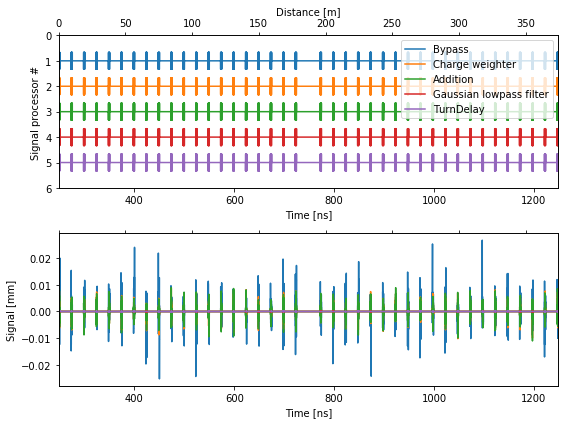

(<Figure size 576x432 with 4 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0935f4ad10>)

In [8]:
beam_minimal = copy.deepcopy(beam_ref)
tracker_minimal = BunchTracker(beam_minimal)
slicer_minimal = copy.deepcopy(slicer_ref)

processors_minimal_x = [
        Bypass(debug=True),
        ChargeWeighter(normalization='segment_average', debug=True),
        NoiseGenerator(RMS_noise_level, debug=True),
        Gaussian(fc, normalization=('bunch_by_bunch', f_harmonic), debug=True),
        TurnDelay(delay, machine.Q_x, n_values,debug=True)
]

processors_minimal_y = [
        Bypass(),
        ChargeWeighter(normalization='segment_average'),
        NoiseGenerator(RMS_noise_level),
        Gaussian(fc, normalization=('bunch_by_bunch', f_harmonic)),
        TurnDelay(delay, machine.Q_y, n_values)
]


feedback_map = OneboxFeedback(feedback_gain,slicer_minimal,
                              processors_minimal_x, processors_minimal_y, mpi = True)
one_turn_map = [feedback_map] + [i for i in trans_map] # + [long_map]

track(n_turns, beam_minimal,one_turn_map,tracker_minimal)
plot_debug_data(processors_minimal_x, source = 'output')

## Results comparison

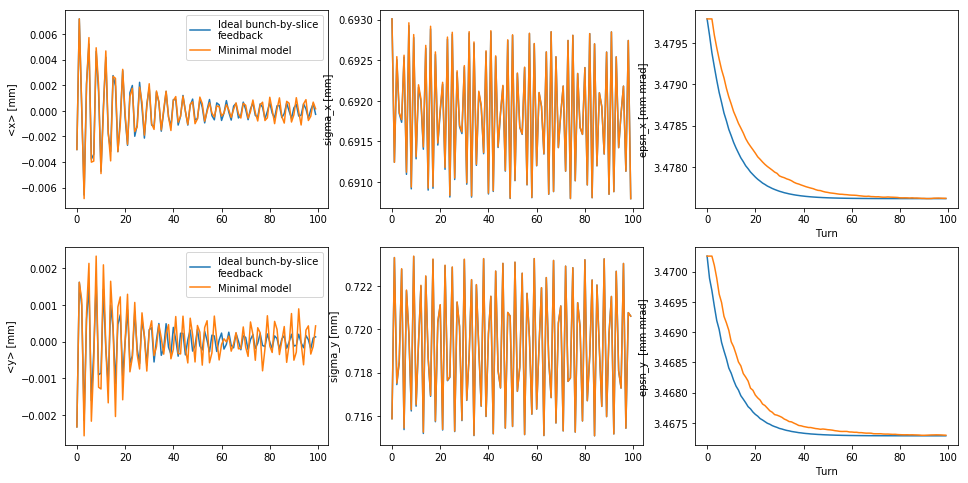

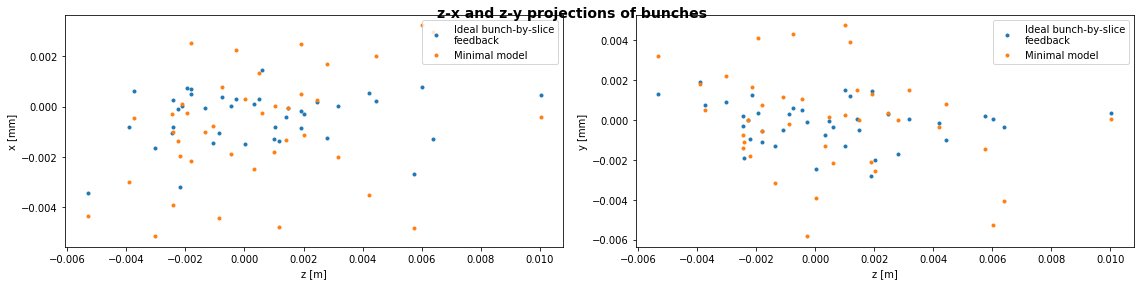

In [9]:
compare_traces([tracker_ref_data,tracker_minimal],
               ['Ideal bunch-by-slice\nfeedback', 'Minimal model'])
compare_beam_projections([ beam_ref_data, beam_minimal], 
               ['Ideal bunch-by-slice\nfeedback', 'Minimal model'])

Jani Komppula, CERN, 2017